# Kanji recognition

This project is about building a [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) to recognize a limited set of [kanji](https://en.wikipedia.org/wiki/Kanji) from a gray image (64x64 pixels) contains a single kanji.

## The kanji list

I will use the [RTK 1 kanji list](memrise_rtk_kanji.txt) which contains about 2000 kanji.

You can obtains your own kanji list by scraping some websites like [wikipedia](https://en.wikipedia.org/wiki/List_of_j%C5%8Dy%C5%8D_kanji) or [memrise](https://www.memrise.com/course/43670/remembering-the-kanji-volume-1/).

In [2]:
# encoding=utf-8
import os
import time
import re
import math

import numpy as np
import pandas

import IPython.display as display

import tensorflow as tf
# tf.enable_eager_execution()

# this is my custom library file that will host all the methods and model architectures
import utilities

In [3]:
kanji_list_filename = 'memrise_rtk_kanji.txt'
df = pandas.read_csv(kanji_list_filename, header=None, encoding='utf-8')
df.head()

,0,1
0,専,46
1,博,47
2,占,48
3,上,49
4,下,50


In [4]:
tf.__version__

'2.0.0-alpha0'

I will generate will python `dict` for convenience when mapping back and forth between  the `kanji` and its `label`.

In [3]:
np_df = df.values
print(np_df.shape)

list_df = np_df.tolist()
print(list_df[:5])

(2199, 2)
[['専', 46], ['博', 47], ['占', 48], ['上', 49], ['下', 50]]


Ops, the kanji list is not sorted.

In [4]:
list_df.sort(key=lambda x: x[1])
print(list_df[:5])

[['一', 1], ['二', 2], ['三', 3], ['四', 4], ['五', 5]]


In [5]:
kanji_list = np.array(list_df)[:, 0]

kanji_dict = {kanji: idx for idx, kanji in enumerate(kanji_list)}
label_dict = {idx: kanji for idx, kanji in enumerate(kanji_list)}

print(kanji_list[:5])
# print(kanji_dict)
# print(label_dict)

['一' '二' '三' '四' '五']


Create a `.py` file for both human readable and ability to import the `kanji_dict` and `label_dict`

In [6]:
output_filename = 'kanji_label_dict.py'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write('# encoding=utf-8\n')

    f.write('kanji_dict = {')
    for idx, key in enumerate(kanji_dict.keys()):
        if idx % 100 == 0:
            f.write('\n')
        f.write(f'\'{key}\': {kanji_dict[key]},')
    f.write('\n}\n')

    f.write('label_dict = {')
    for idx, key in enumerate(label_dict.keys()):
        if idx % 100 == 0:
            f.write('\n')
        f.write(f'{key}: \'{label_dict[key]}\',')
    f.write('\n}\n')

## Dataset

Create a nice and clean dataset may be one of the most mundane task.

Here are some places to find the dataset:

- [ETL Character Database](http://etlcdb.db.aist.go.jp/)
- [CASIA](http://www.nlpr.ia.ac.cn/databases/handwriting/Home.html)


I created my own dataset by using `pillow`. Here are the steps that I used:

1. Search the internet for Japanese fonts.

Most of them are handwriting fonts. 

[Here](https://www.freejapanesefont.com/) is great resource for finding Japanese fonts.

2. Load the font using `PIL.ImageFont` and draw kanji on a blank image with `PIL.ImageDraw` and save to disk.

**Note**: Saving thousands of small files to disk was a terrible idea. However, I need to inspect the image to clean the dataset. If the font does not support some characters, the result image will be **blank** or **tofu** shape.

3. After verifying all the images (remove **tofu** images), I performs some data augmentation methods.

I did rotate all images by `10` and `-10` degrees.

I did not translate the image because that will increase the complexity and put unnessesary stress on the network.

All data augmenation are performed in memory then written to single `TFRecord` file.

In [2]:
# this is the generated python file that has the `kanji_dict` and `label_dict`
import kanji_label_dict as kld

Let's preview the dataset

Require `eager execution` enabled.

In [8]:
tfrecord_filename = 'kanji_dataset.tfrecord'

raw_image_dataset = tf.data.TFRecordDataset(tfrecord_filename)

def _parse_image_function(example_proto):
    # feature dictionary
    image_feature_description = {
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
    }
    return tf.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<DatasetV1Adapter shapes: {image_raw: (), label: ()}, types: {image_raw: tf.string, label: tf.int64}>

Instructions for updating:
Colocations handled automatically by placer.


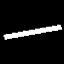

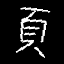

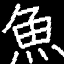

In [9]:
preview_indies = [2, 7000, 20000]

for idx, image_features in enumerate(parsed_image_dataset):
    if idx in preview_indies:
        image_raw = image_features['image_raw'].numpy()
        label = image_features['label'].numpy()
        kanji = kld.label_dict[int(label)]
        display.display(display.Image(data=image_raw))
        display.display(display.HTML(f'index: {idx} - kanji: {kanji} - label: {label}'))
        
        if idx == preview_indies[-1]:
            break

In [11]:
del parsed_image_dataset

## Train the model

After having the dataset, the only thing left is press the training button.

In [5]:
# model = utilities.kanji_model_v1()
model = utilities.kanji_model_v3()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_NUM_1 (Conv2D)        (None, 48, 48, 32)        9280      
_________________________________________________________________
Dropout_NUM_1 (Dropout)      (None, 48, 48, 32)        0         
_________________________________________________________________
MaxPool2D_NUM_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
Conv2D_NUM_2 (Conv2D)        (None, 20, 20, 64)        51264     
_________________________________________________________________
Dropout_NUM_2 (Dropout)      (None, 20, 20, 64)        0         
_________________________________________________________________
MaxPool2D_NUM_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
Conv2D_NUM_3 (Conv2D)        (None, 8, 8, 128)         7

In [3]:
class MyClassback(tf.keras.callbacks.Callback):
    def __init__(self, model_prefix: str, save_dir: str):
        self.prefix = model_prefix
        self.save_dir = save_dir
        self.last_acc = None

    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('acc')

        if self.last_acc is None:
            self.last_acc = acc
        else:
            if self.last_acc > acc:
                self.save_model_weights(epoch, acc)
                
            self.last_acc = acc
            
        if acc >= 0.97:
            self.model.stop_training = True
            self.save_model_weights(epoch, acc)
        elif epoch % 2 == 0:
            self.save_model_weights(epoch, acc)
        
    def save_model_weights(self, epoch, acc):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        model_weights_filename = f'{self.save_dir}/{self.prefix}_epoch_{str(epoch).zfill(2)}_acc_{acc:.2f}_{utilities.time_now()}.h5'
        self.model.save_weights(model_weights_filename)

In [4]:
callback = MyClassback('kanji_model_v3', 'kanji_model_v3')

In [5]:
# the number of samples is 256776 (the last time I keep track of it)
buffer_size = 256776
# buffer_size = 256
batch_size = 256
steps_per_epoch = math.ceil(buffer_size / batch_size)

tfrecord_filename = 'kanji_dataset.tfrecord'
ds = utilities.load_tfrecord(tfrecord_filename)
ds = ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=buffer_size))
ds = ds.batch(batch_size)
ds

<DatasetV1Adapter shapes: ((?, 64, 64, 1), (?,)), types: (tf.float32, tf.int64)>

In [6]:
history = model.fit(
    ds,
    epochs=8,
    steps_per_epoch=steps_per_epoch,
    callbacks=[callback],
)

Epoch 1/8
1004/1004 [==============================] - 165s 164ms/step - loss: 2.5936 - acc: 0.5379
Epoch 2/8
1004/1004 [==============================] - 112s 111ms/step - loss: 0.2454 - acc: 0.9279
Epoch 3/8
1004/1004 [==============================] - 101s 101ms/step - loss: 0.1231 - acc: 0.9616
Epoch 4/8
1004/1004 [==============================] - 101s 100ms/step - loss: 0.0912 - acc: 0.9714


In [7]:
import matplotlib.pyplot as plt

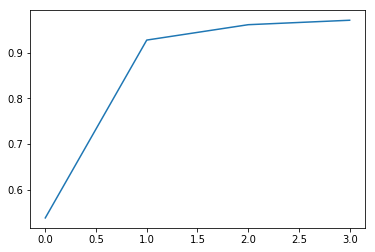

In [8]:
plt.plot(history.epoch, history.history['acc'])

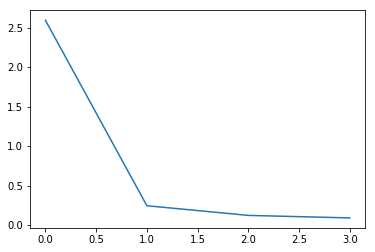

In [9]:
plt.plot(history.epoch, history.history['loss'])

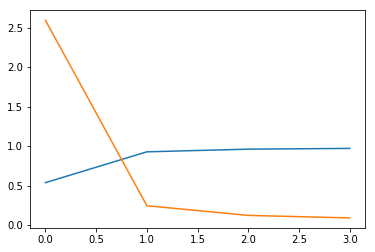

In [10]:
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['loss'])

In [11]:
model_filename = 'kanji_model_v3.h5'
model.save(model_filename)